# Homework 5 - An Analysis of Shakespeare using Clustering Techniques

There are three parts to this notebook:
* <a href="#the_walkthrough">A general discussion of our analysis</a>,
* <a href="#the_details">The details for each step</a>,
* <a href="#exploratory_points">Exploratory Points<a>


<a id='the_walkthrough'></a>

# The Walkthrough

## Data Preparation

Our first step was to download and parse the text files. We decided to utilse the XML files prepared by <a href='http://www.ibiblio.org/bosak/'>John Bosak</a>. As the XML files had a well defined structure, parsing it with an XML parser (we used xml.etree.ElementTree) was relatively simple. (Please note that prof. Peter aproved the usage of the XML files trough a post on Piazza). 
<br />
The file <a href="dataset.py">dataset.py</a> is responsible for reading the files in and writing out a pickle, dataset.pickle, that stores all plays in a pandas dataframe.

### General Frequency of Words

We next loaded the dataset and looked at the frequencies of the words in all the plays. Displaying the top 100 in a word cloud exposed some interesting issues with Shakespearean words. 
<img width="800" src='files/wordcloud.png'/>
It is interesting to see some 'Olde English' words in there - thee, thou, etc. The modern day Python libraries will obviously be using modern day English libraries and so we'll need to be careful to take into account the older style of English.

### POS Tagging

Part Of Speech (POS) tagging allows us to identify the structure of the sentence. This is particularly useful in removing proper nouns, such as people's names. For example, you would epect to see a large number of occurances of the word Macbeth  in the play Macbeth, but how much information is it actually giving us? We therefore investigated whether it would be usefule to remove proper nouns with the uintention of testing both scenarios.

In the <a href="#pos_tagging">code</a> we use pos_tag from NLTK to remove the proper nouns ('NNP') from all the plays. The results were, however, disappointing: we do indeed remove Macbeth, but would also remove countries such as Scotland, England, Ireland and other words that definately aren't proper nouns: show, began, which, speak, witch. That last one is definetely a problem as Macbeth without witches would be a tragedy!

## Visualisation

For our exploration of visualisation techniques we will investigate whether we can cluster the plays into their types: comedies, tragedies, historical and Roman.

###MDS

Examining four clusters from the plays we can clearly see the Roman and Historical plays in clusters 3 and 4. The majority of the comedies are present in the second cluster, however the first cluster isn't quite as clean and has tragedies plus a bit of everything else.
<img src='mds_plays_4clusters.png'/>

<a id='the_details'></a>

# The Details

This section provides the details of our analysis. Some of the steps are computationally expensive - these will be pointed out.

That that you may need to run the following commands:
* pip install wordcloud
* nltk.download()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud # pip install wordcloud
# #nltk.download()

%matplotlib inline  

# Helper class that loads and parses the XML files
%run 'dataset.py'
%run 'processing.py'

In [ ]:
ds = DataSet()
ds.load()

tokens = Processing.get_tokens(ds.df['Utterance'], [Processing.remove_punctuation], [Processing.remove_stopwords])

allWordDist = nltk.FreqDist(tokens)

common_words = allWordDist.most_common(100)

# Print the top 20 words - shows some 'olde english' stop words
print('Hundred most common words:')
print(allWordDist.most_common(100))

cloud_words = ' '.join(entry[0] for entry in common_words)


# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=80,height=600, width=1200).generate(cloud_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', dpi=200)
plt.show()

<a id='pos_tagging'></a>

## POS Tagging

In order to identify whether POS tagging was effective we concatenated all utterances in all plays. We displayed the ressults of the words that pos_tag deemed as proper nouns for the play Macbeth: the results were disappointing.

In [6]:
plays_utterances = ds.get_by_play()

In [7]:
# Strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
# Requires average_perceptron_tagger from NLTK download
from nltk.tag import pos_tag

for title, text in plays_utterances.items():
    tokens = nltk.word_tokenize(text)
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    propernouns = [word for word,pos in tagged if pos == 'NNP' ]

    
    if( title == 'macbeth'):
        print('Play: Macbeth')
        print('Proper Nouns: ',propernouns)



Play: Macbeth
Proper Nouns:  ['Macbeth', 'Graymalkin', 'Paddock', 'Anon', 'Fair', 'Hover', 'Who', 'Hail', 'Say', 'Macdonwald', 'Do', 'Show', 'Macbeth', 'Disdaining', 'Which', 'Till', 'Which', 'Till', 'O', 'Discomfort', 'Mark', 'Scotland', 'Norweyan', 'Began', 'Dismay', 'Macbeth', 'Banquo', 'Or', 'Golgotha', 'Go', 'Ross', 'God', 'Whence', 'Fife', 'Norweyan', 'Norway', 'Cawdor', 'Till', 'Bellona', 'Point', 'Great', 'Sweno', 'Norways', 'Till', 'Saint', 'Colme', 'Cawdor', 'Macbeth', 'Macbeth', 'Sister', "'d", "'d", 'Aleppo', "Thou'rt", 'Hang', 'Shall', 'Wreck', 'Macbeth', 'Posters', 'Thus', 'Speak', 'Macbeth', 'Glamis', 'Macbeth', 'Cawdor', 'Macbeth', 'Are', 'ye', 'Which', 'Speak', 'Macbeth', 'Thou', 'Macbeth', 'Banquo', 'Banquo', 'Macbeth', 'Stay', 'Sinel', 'Glamis', 'Cawdor', 'Cawdor', 'A', 'Stands', 'No', 'Cawdor', 'Say', 'Speak', 'Cawdor', 'Macbeth', 'Thy', 'Which', 'Norweyan', 'Strange', 'As', 'Came', 'Thy', 'Cawdor', 'Cawdor', 'Who', 'Which', 'Norway', 'Glamis', 'Cawdor', 'Cawdor', '

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer




stemmer = SnowballStemmer("english")


def run_tfidf(words, stem=False, max_features=10000):
    all_stopwords = stopwords.words('english') 

    #adding Shakespeare-ean stop-words
    shaksp_stopwords = ('thee', 'thou', 'thy', 'thine')
    all_stopwords += shaksp_stopwords

    tfidf_vectorizer = TfidfVectorizer(#max_features=200000,
                                        max_features=max_features,
                                        min_df=0.2, 
                                        max_df=0.8, 
                                        stop_words=all_stopwords,
                                        use_idf=True, 
                                        tokenizer=tokenize_and_stem if stem else tokenize_only, 
                                        ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(words)
    
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()


def strip_proppers_POS(tokens):
    tagged = pos_tag(tokens) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

    
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    filtered_tokens = strip_proppers_POS(filtered_tokens)
    
    return filtered_tokens    
    


### The Data

For our analysis we'll primarily be looking at:
* all the words grouped by plays, plays_utterances below,
* all the words grouped by speakers, speaker_utterances below.


In [36]:
plays_utterances = ds.get_by_play()
tfidf_matrix_plays, terms_plays = run_tfidf(plays_utterances.values())

speakers_utterances = ds.get_by_speaker()
tfidf_matrix_speakers, terms_speakers = run_tfidf(speakers_utterances.values())

<a id='kmeans_details'></a>

## KMeans

In [10]:
from sklearn.cluster import KMeans
from collections import Counter
import pickle


def run_single_kmeans(X, max_iter=300, n_init=10, range_clusters = range(5,6), title=None):
    """
    Run KMeans algorithm for the supplied parameters.
    
    :param tfidf_matrix: the data to cluster on
    :param max_iter: the maximum iterations that KMeans algorithm will run 
    :param n_init=10: the maximum iterations that KMeans algorithm will run 
    :param range_clusters: the clusters to generate
    :param title: the prefix to give to the pickle. If None, do not save the results
    :return: a pandas dataframe with the results of the clustering
    """
    kms = []
    
    for num_clusters in range_clusters:
        print('KMeans cluster ', num_clusters)

        km = KMeans(n_clusters=num_clusters,
                    init='k-means++',
                    max_iter=max_iter,             # Default is 300
                    n_init=n_init,                 # Default is 10
                    precompute_distances=True, # Faster but takes more memory
                    random_state=47,
                    n_jobs=-1)

        cluster_labels = km.fit(X)


        kms.append( {'num_clusters': num_clusters, 
                    'cluster_centers':km.cluster_centers_, 
                    'clusters':km.labels_.tolist(), 
                    'inertia':km.inertia_,
                    'cluster_labels': km.labels_ })
    
    kms_df = pd.DataFrame(kms, index=range_clusters)

    if title is not None:
        kms_df.to_pickle('kms_{}_{}_{}.pickle'.format(title, max_iter, n_init))
        
    return kms_df


            
            
def run_kmeans(tfidf_matrix, max_clusters, title=None):
    """
    Run a grid search to identify whether changing max_iters 
    and n_inits has a bit influence on the result.
    """
    max_iters = [1, 10, 100, 300, 1000, 10000]
    n_inits = [1, 5, 10, 50, 100]
    range_clusters = range(1, max_clusters)
    
    kms_df = None
    
    for max_iter in max_iters:
        print('Max iter: ', max_iter)
        for n_init in n_inits:
            print('n_init: ', n_init)
          
            run_single_kmeans(tfidf_matrix, max_iter, n_init, title=title)
    

            

# The following lines are deliberately commented out
# They will find the hyper-parameters for max_iters and n_init
#run_kmeans(tfidf_matrix_plays, len(plays_utterances))
#run_kmeans(tfidf_matrix_plays, len(speakers_utterances))





In [11]:
# Run a KMeans on the plays with max_iter=1, n_init=10 - for comparison
run_single_kmeans(tfidf_matrix_plays, 
                                 max_iter=1, n_init=10, range_clusters = range(1,6), title='plays')

# Run again using a decent max_iter and n_init
kms_df_plays = run_single_kmeans(tfidf_matrix_plays, 
                                 range_clusters = range(1,6), title='plays')

KMeans cluster  1
KMeans cluster  2
KMeans cluster  3
KMeans cluster  4
KMeans cluster  5
KMeans cluster  1
KMeans cluster  2
KMeans cluster  3
KMeans cluster  4
KMeans cluster  5


In [43]:
# Run K-Means with k = max (971) - will take a long time
if False:
    size_speakers = tfidf_matrix_speakers.shape[0]

    # Run a KMeans on the speakers with max_iter=1, n_init=10 - for comparison
    run_single_kmeans(tfidf_matrix_speakers, 
                        max_iter=1, n_init=10, 
                        range_clusters = range(1,size_speakers), title='speakers')

    # Run again using a decent max_iter and n_init
    kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, 
                                        range_clusters = range(1,size_speakers), title='speakers')

kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, 
                                    max_iter=1, n_init=10,
                                    range_clusters = range(1,100), title='speakers')

#kms_df_speakers = run_single_kmeans(tfidf_matrix_speakers, 
#                                    range_clusters = range(1,100), title='speakers')

KMeans cluster  1
KMeans cluster  2
KMeans cluster  3
KMeans cluster  4
KMeans cluster  5
KMeans cluster  6
KMeans cluster  7
KMeans cluster  8
KMeans cluster  9
KMeans cluster  10
KMeans cluster  11
KMeans cluster  12
KMeans cluster  13
KMeans cluster  14
KMeans cluster  15
KMeans cluster  16
KMeans cluster  17
KMeans cluster  18
KMeans cluster  19
KMeans cluster  20
KMeans cluster  21
KMeans cluster  22
KMeans cluster  23
KMeans cluster  24
KMeans cluster  25
KMeans cluster  26
KMeans cluster  27
KMeans cluster  28
KMeans cluster  29
KMeans cluster  30
KMeans cluster  31
KMeans cluster  32
KMeans cluster  33
KMeans cluster  34
KMeans cluster  35
KMeans cluster  36
KMeans cluster  37
KMeans cluster  38
KMeans cluster  39
KMeans cluster  40
KMeans cluster  41
KMeans cluster  42
KMeans cluster  43
KMeans cluster  44
KMeans cluster  45
KMeans cluster  46
KMeans cluster  47
KMeans cluster  48
KMeans cluster  49
KMeans cluster  50
KMeans cluster  51
KMeans cluster  52
KMeans cluster  53
KM

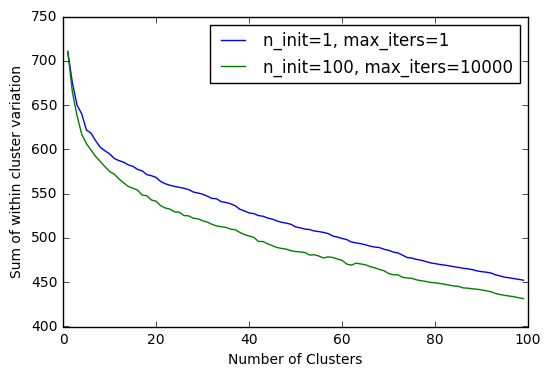

In [44]:

def plot_two(kms1, label1, kms2, label2):
    fig, ax = plt.subplots()
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of within cluster variation')
    plt.plot(kms1.num_clusters, kms1.inertia, label=label1)
    plt.plot(kms2.num_clusters, kms2.inertia, label=label2)
    plt.legend(loc='upper right')
    plt.savefig('km_variation_both.png', dpi=200)
    plt.show()


# For the plays, plot the variation as a fn of the number of clusters
# Compare the difference when running with
#  i) n_init=1, max_iters=1
# ii) n_init=100, max_iters=10000

kms_df1_1 = pd.read_pickle('kms_speakers_1_10.pickle')
kms_df10000_100 = pd.read_pickle('kms_speakers_300_10.pickle')
plot_two(kms_df1_1, 'n_init=1, max_iters=1', kms_df10000_100, 'n_init=100, max_iters=10000')




In [75]:
def make_frame(utterances, clusters):

    plays_dict = { 'title': list(utterances.keys()),'cluster': clusters}

    frame = pd.DataFrame(plays_dict, index = [clusters] , columns = [
            'title', 'cluster'])
    return frame

    

frame_plays = make_frame(plays_utterances, kms_df_plays.iloc[3].clusters)

# From the diagram, above, it looks like there may be an elbow around 5
frame_speakers = make_frame(speakers_utterances, kms_df_speakers.iloc[4].clusters)


In [76]:

# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in plays_utterances.values():
#     allwords_stemmed = tokenize_and_stem(i)
#     totalvocab_stemmed.extend(allwords_stemmed)
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)


In [77]:
 def top_terms(frame, km, terms):
    print("Top terms per cluster:")
    print()
    order_centroids = km.cluster_centers.argsort()[:, ::-1]
    for i in range(km.num_clusters):

        print("Cluster {} words:".format(i))
        for ind in order_centroids[i, :10]:
            print(' {}'.format(terms[ind]))
        print()

        print("Cluster {} titles:".format(i))
        for title in frame['title'].values.tolist():
            print(' {},'.format(title))
        print()
        print()
    

top_terms(frame_plays, kms_df_plays.iloc[3], terms_plays)
#top_terms(frame_speakers, kms_df_speakers.iloc[4], terms_speakers)

Top terms per cluster:

Cluster 0 words:
 ambassadors
 able
 'd 'll
 bleed
 's past
 assume
 approved
 borrow
 bald
 alone 'll

Cluster 0 titles:
 r_and_j,
 pericles,
 dream,
 t_night,
 rich_ii,
 lll,
 hamlet,
 as_you,
 much_ado,
 m_for_m,
 john,
 merchant,
 cymbelin,
 tempest,
 com_err,
 hen_vi_3,
 hen_v,
 j_caesar,
 hen_iv_1,
 a_and_c,
 two_gent,
 lear,
 m_wives,
 hen_vi_1,
 macbeth,
 hen_iv_2,
 rich_iii,
 all_well,
 win_tale,
 hen_vi_2,
 hen_viii,
 timon,
 coriolan,
 taming,
 troilus,
 othello,
 titus,


Cluster 1 words:
 brown
 appoint
 ay good
 bend
 's fault
 's person
 's none
 albeit
 beggars
 aspect

Cluster 1 titles:
 r_and_j,
 pericles,
 dream,
 t_night,
 rich_ii,
 lll,
 hamlet,
 as_you,
 much_ado,
 m_for_m,
 john,
 merchant,
 cymbelin,
 tempest,
 com_err,
 hen_vi_3,
 hen_v,
 j_caesar,
 hen_iv_1,
 a_and_c,
 two_gent,
 lear,
 m_wives,
 hen_vi_1,
 macbeth,
 hen_iv_2,
 rich_iii,
 all_well,
 win_tale,
 hen_vi_2,
 hen_viii,
 timon,
 coriolan,
 taming,
 troilus,
 othello,
 titus,


<a id='mds_details'></a>

## MDS

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

def calc_mds(tfidf_matrix):
    dist = 1 - cosine_similarity(tfidf_matrix)

    # two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]
    
    return dist, xs, ys

dist_plays, xs_plays, ys_plays = calc_mds(tfidf_matrix_plays)
dist_speakers, xs_speakers, ys_speakers = calc_mds(tfidf_matrix_speakers)

In [86]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names_plays = {0: 'Misc', 
                 1: 'Comedies', 
                 2: 'History', 
                 3: 'Roman', 
                 4: '4'}

cluster_names = {0: '0', 
                 1: '1', 
                 2: '2', 
                 3: '3', 
                 4: '4'}

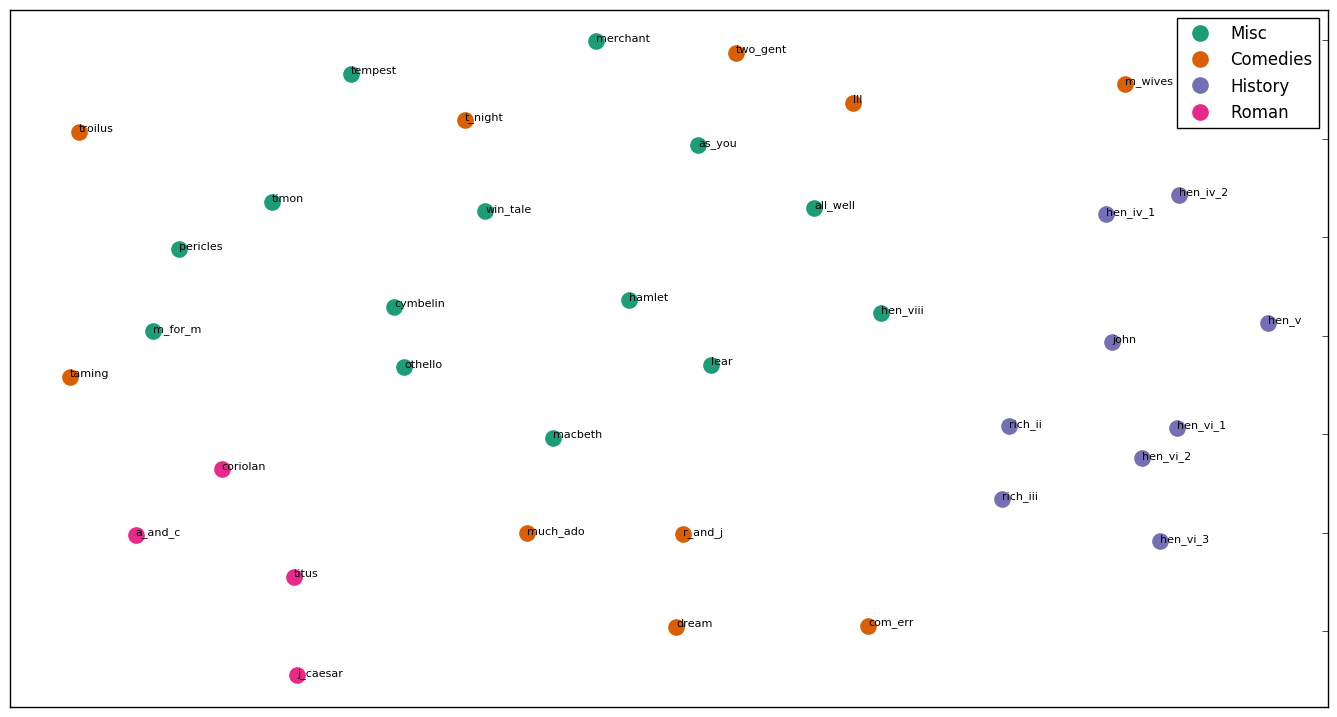

In [89]:
%matplotlib inline

def display_mds_plot(frame, xs, ys, cluster_names):
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=frame['cluster'], title=frame['title'])) 

    #group by cluster
    groups = df.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that we use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i, row in df.iterrows():
        ax.text(row['x'], row['y'], row['title'], size=8)  



    plt.show() #show the plot

    #uncomment the below to save the plot if need be
    #plt.savefig('clusters_small_noaxes.png', dpi=200)
    
display_mds_plot(frame_plays, xs_plays, ys_plays, cluster_names_plays)


The same technique used on the speakers doesn't work as well

<a id='hdc_details'></a>

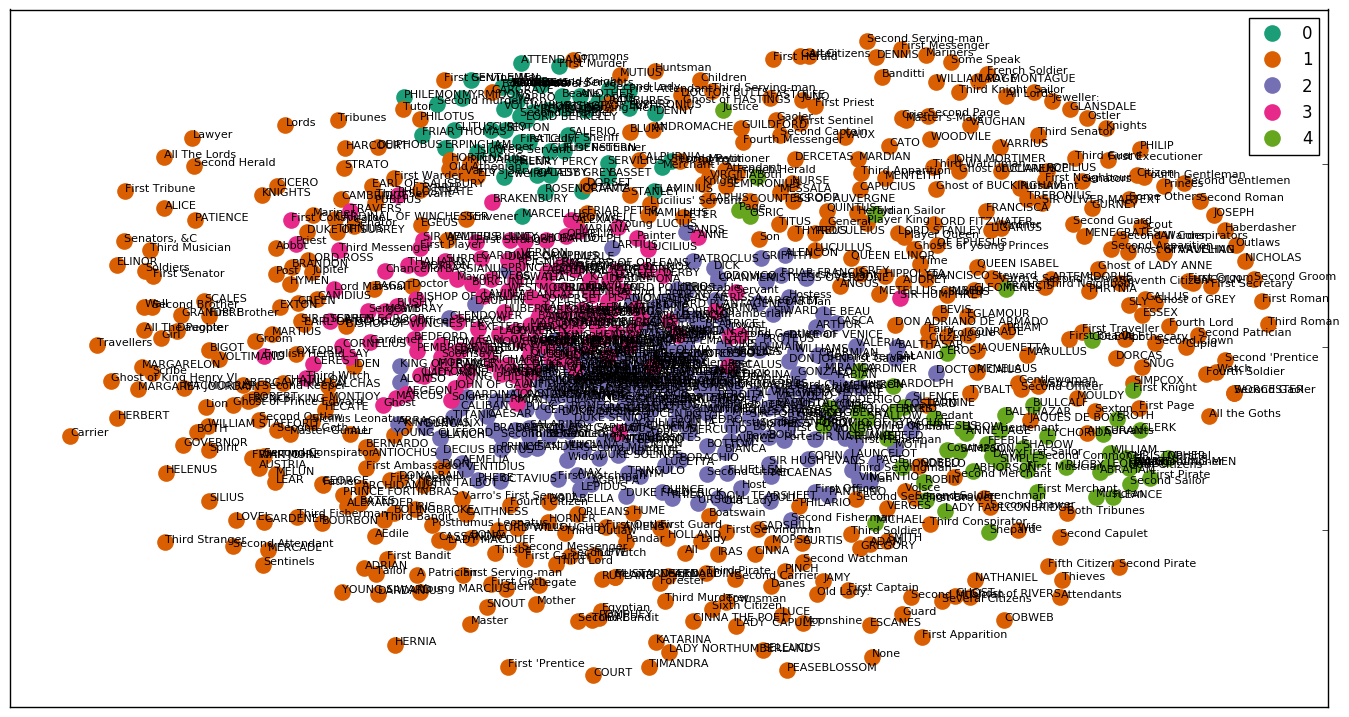

In [88]:
display_mds_plot(frame_speakers, xs_speakers, ys_speakers, cluster_names)

## Hierarchical Document Clustering

In [27]:
print(dist_speakers)

[[ -2.22044605e-16   3.52496493e-01   6.84072760e-01 ...,   3.09788756e-01
    6.58070406e-01   5.00740703e-01]
 [  3.52496493e-01   0.00000000e+00   7.57189936e-01 ...,   4.98204950e-01
    7.08444499e-01   6.62632833e-01]
 [  6.84072760e-01   7.57189936e-01   0.00000000e+00 ...,   8.22781940e-01
    8.81311256e-01   7.97091488e-01]
 ..., 
 [  3.09788756e-01   4.98204950e-01   8.22781940e-01 ...,  -2.22044605e-16
    7.11891705e-01   5.02098975e-01]
 [  6.58070406e-01   7.08444499e-01   8.81311256e-01 ...,   7.11891705e-01
   -4.44089210e-16   8.07752082e-01]
 [  5.00740703e-01   6.62632833e-01   7.97091488e-01 ...,   5.02098975e-01
    8.07752082e-01  -8.88178420e-16]]


In [98]:
from scipy.cluster.hierarchy import ward, dendrogram

def display_ward(frame, dist):
    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels=list(frame.title));

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout

    #uncomment below to save figure
    plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
    plt.show()
    


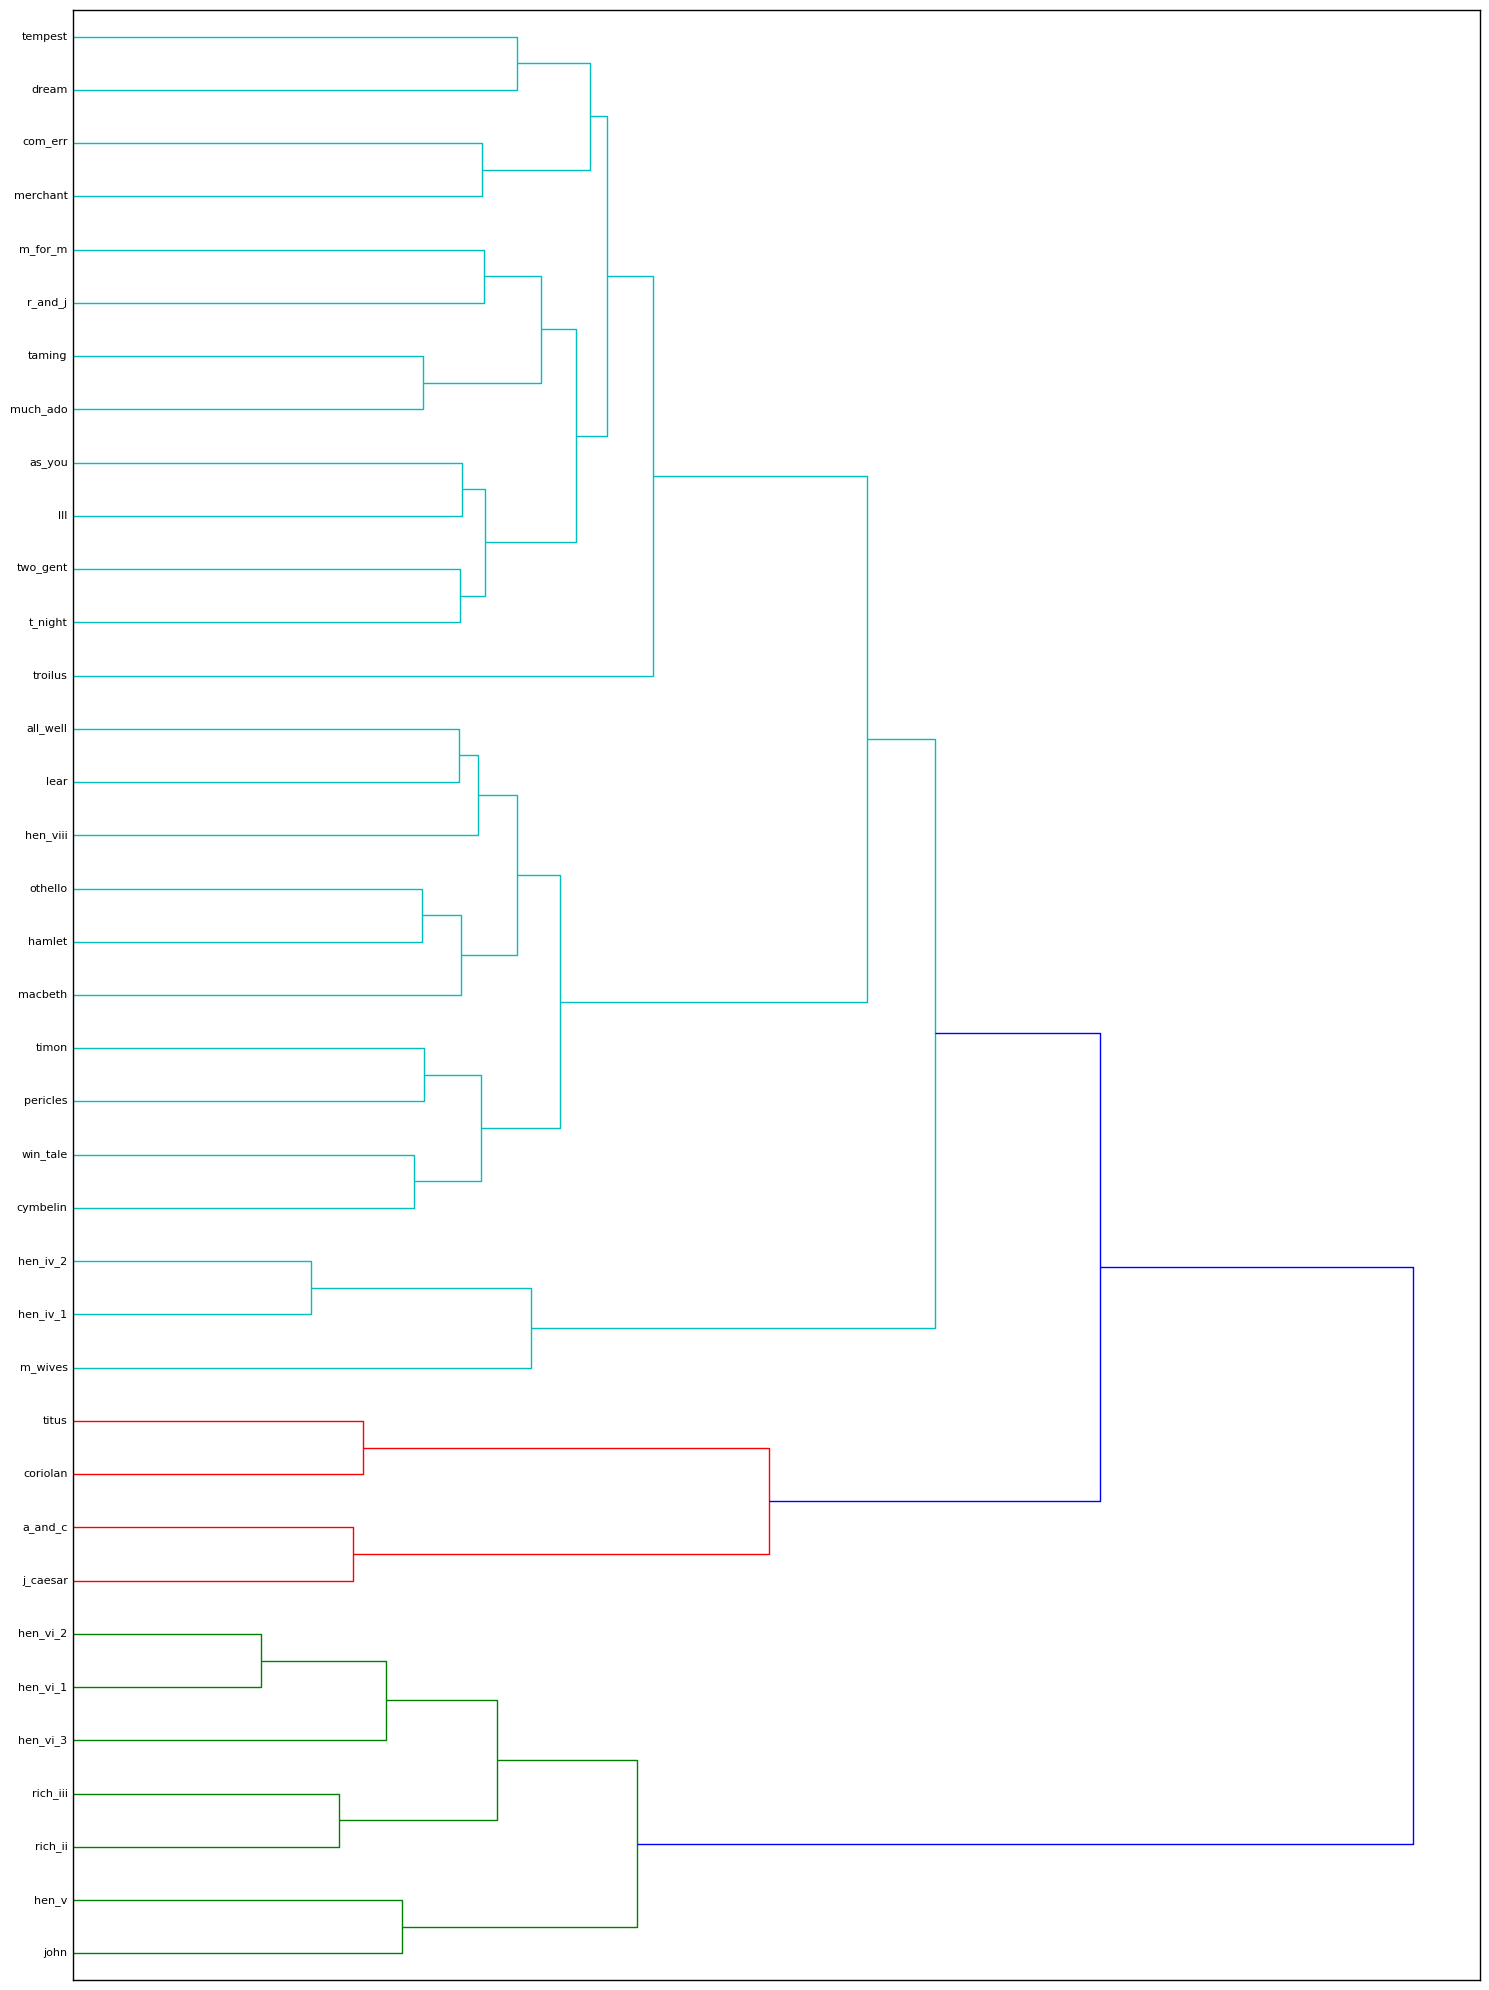

In [99]:
display_ward(frame_plays, dist_plays)

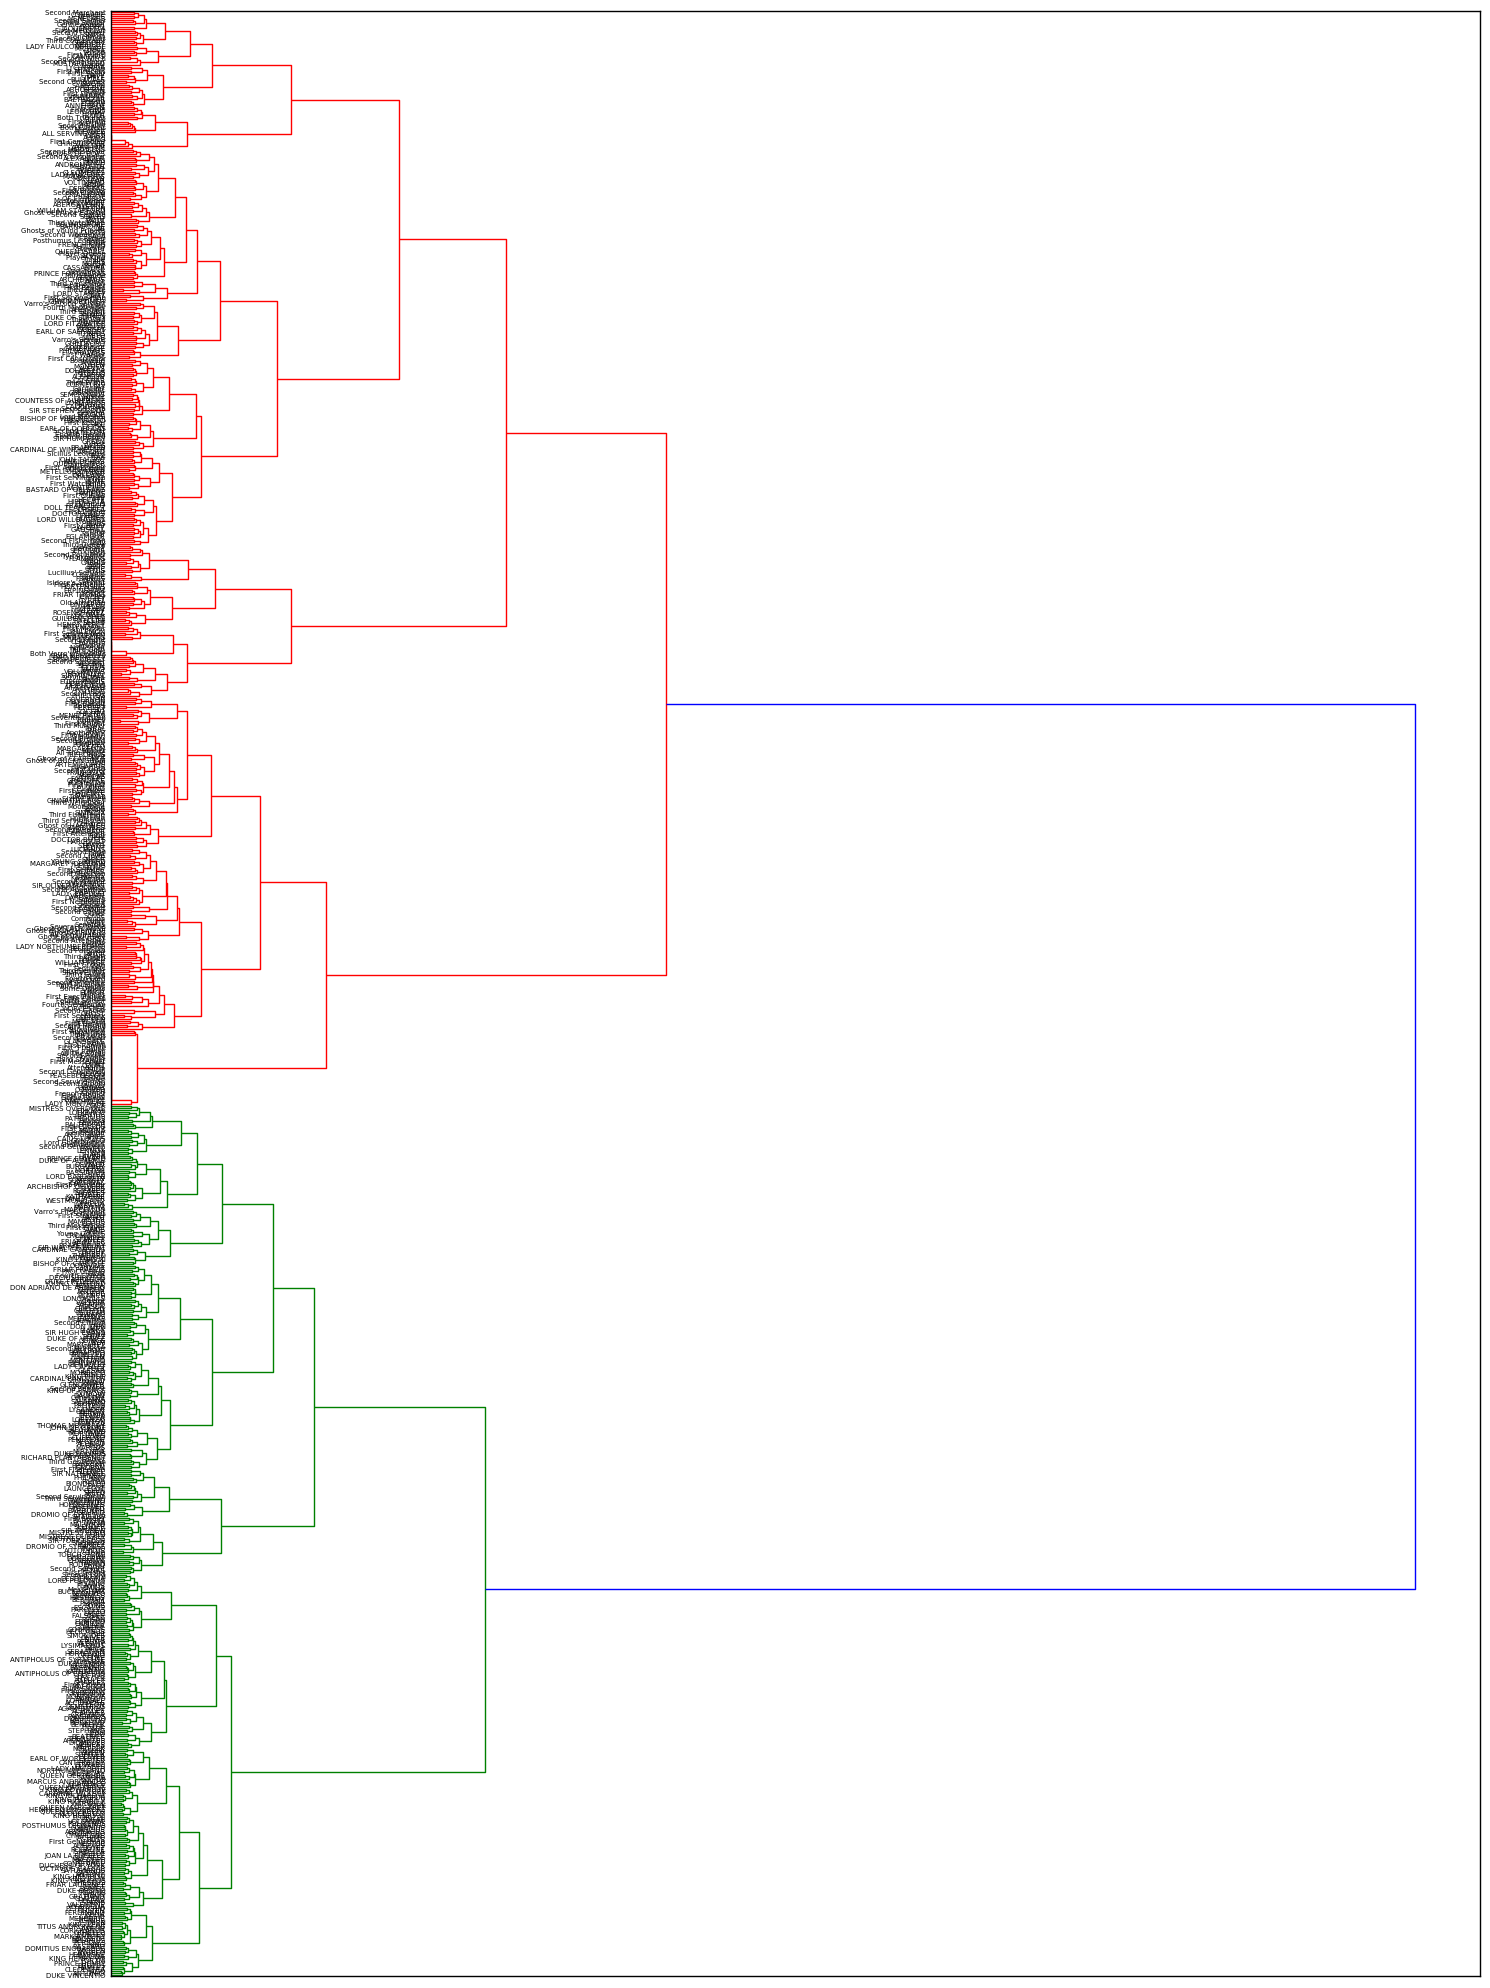

In [29]:
display_ward(frame_speakers, dist_speakers)

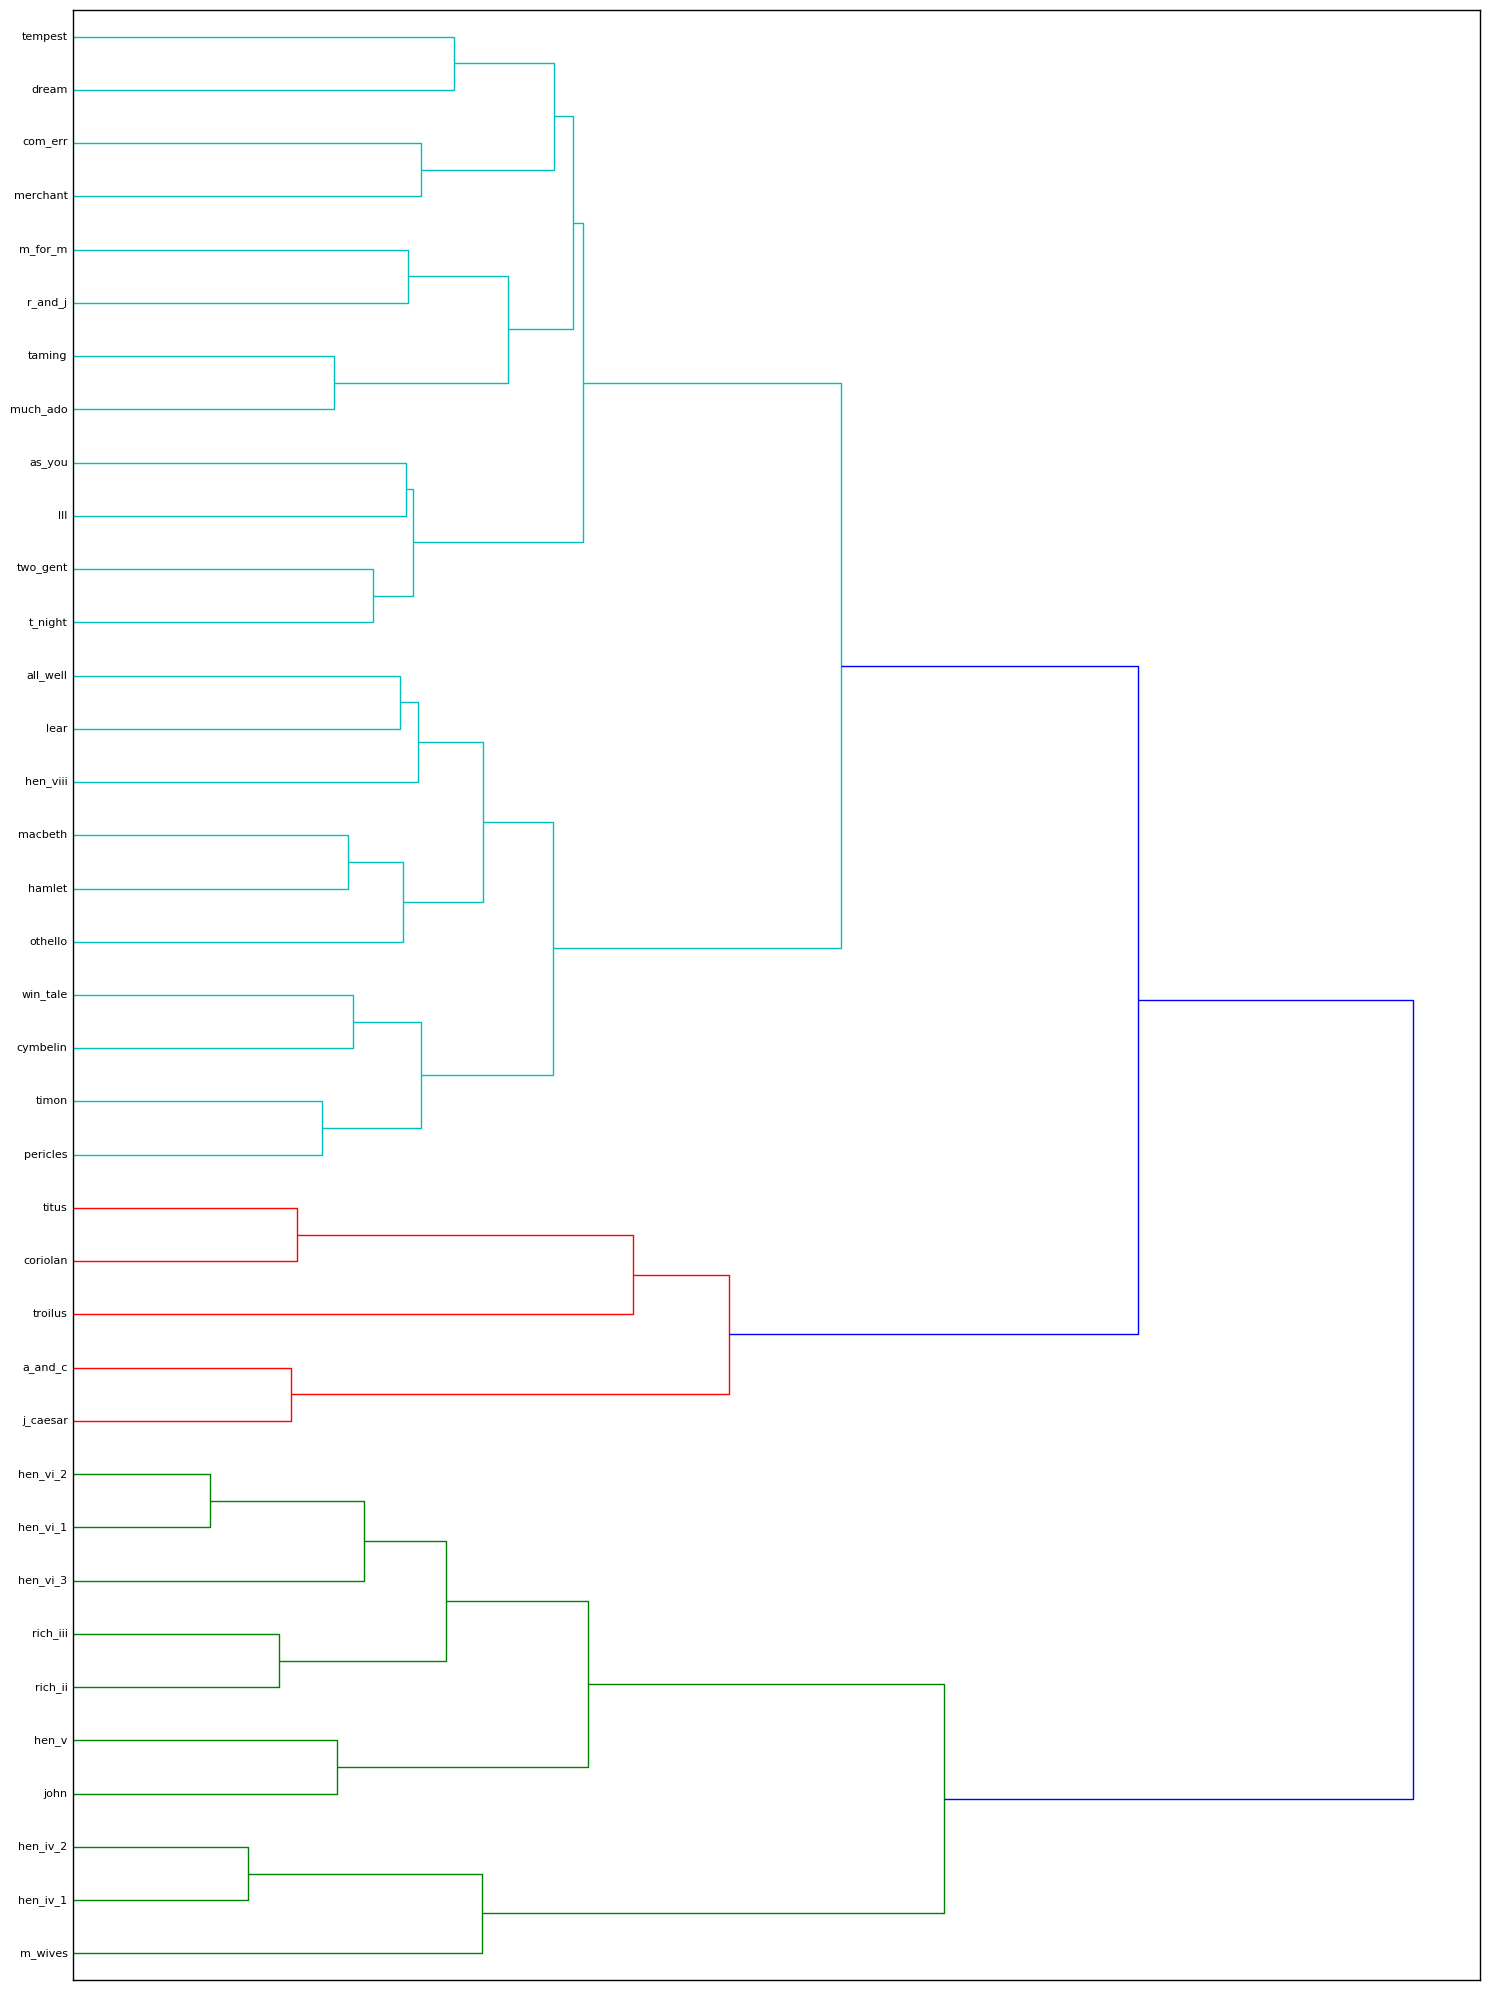

In [30]:
display_ward(frame_plays, dist_plays)

## Self Organising Map

In [31]:
# Using SOMOCLO https://arxiv.org/abs/1305.1422
#import somoclu # pip install somoclu

#n_rows, n_columns = 100, 160
#data=np.asarray(list(plays_utterances.values))
#som = somoclu.Somoclu(n_columns, n_rows, data=data)
#som.train()


<a id='silhouette_details'></a>

## Silhouette Plots

In [32]:
print((kms_df_speakers.cluster_labels))

1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...
3      [1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, ...
4      [0, 0, 3, 2, 3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 3, ...
5      [0, 4, 3, 1, 3, 4, 4, 1, 4, 3, 3, 0, 4, 3, 3, ...
6      [0, 0, 5, 1, 2, 0, 0, 1, 4, 5, 2, 4, 0, 2, 2, ...
7      [6, 6, 1, 5, 4, 6, 6, 5, 0, 1, 4, 6, 6, 4, 4, ...
8      [3, 3, 4, 6, 7, 3, 5, 6, 5, 4, 7, 1, 5, 7, 7, ...
9      [2, 2, 5, 6, 7, 2, 1, 8, 1, 5, 7, 2, 1, 7, 7, ...
10     [3, 3, 4, 6, 7, 3, 5, 1, 8, 8, 7, 1, 5, 7, 7, ...
11     [3, 3, 9, 6, 7, 3, 1, 8, 1, 10, 7, 4, 1, 7, 7,...
12     [5, 5, 9, 2, 3, 5, 7, 8, 10, 1, 3, 6, 0, 3, 3,...
13     [5, 5, 9, 2, 3, 11, 7, 8, 10, 1, 3, 5, 0, 0, 1...
14     [5, 5, 0, 2, 3, 9, 13, 8, 10, 1, 3, 13, 9, 3, ...
15     [8, 8, 14, 12, 13, 11, 5, 1, 4, 4, 13, 3, 11, ...
16     [9, 9, 15, 2, 3, 11, 13, 8, 10, 15, 3, 13, 0, ...
17     [12, 12, 10, 6, 7, 12, 1, 8, 2, 10, 7, 4, 3, 7...
18     [12, 12, 10, 6, 7, 12, 1

In [33]:
from sklearn.metrics import silhouette_score

def silhouette_plot(kms, X):
    """
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    range_n_clusters = range(1, len(kms))
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        #cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters

        silhouette_avg = silhouette_score(X, kms.cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, kms.cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [972, 971]

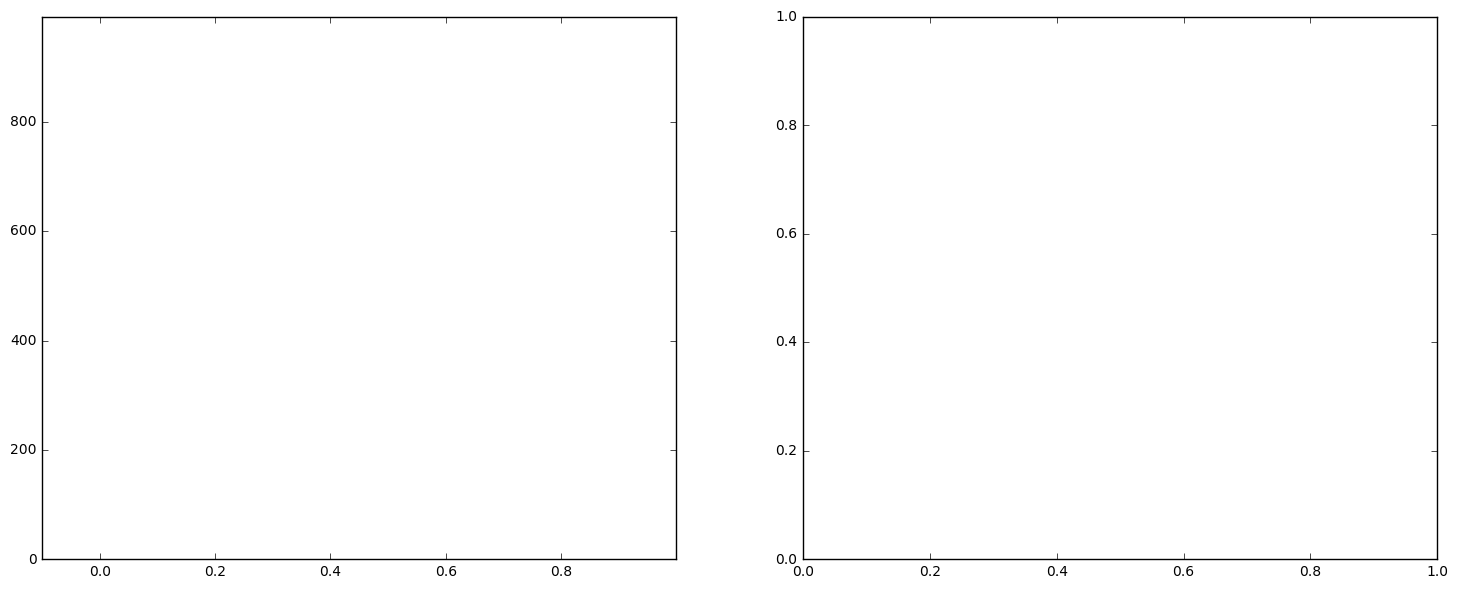

In [34]:
silhouette_plot(kms_df_speakers, tfidf_matrix_speakers)

## Purity Measures, Contingenct Tables, Entropy

## PCA

<a id='exploratory_points'></a>

# Exploratory Points